# Level 4: Agentic & MCP (Medium Difficulty)

This tutorial is for developers who are already familiar with [basic Agentic workflows](./Level2_simple_agentic_with_websearch.ipynb). 
This tutorial will highlight a couple of slightly more advanced use cases for agents where a single tool call is insufficient to complete the required task. Here we will rely on both sequential agent calls and conditional logic to expand our agents capabilities. 

We will also use [MCP tools](https://github.com/modelcontextprotocol/servers) hosted locally or on an OpenShift cluster throughout this demo to showcase how users can go beyond Llama Stacks's current set of builtin tools to connect to many different services and data sources to build their own custom agents.  

### Agent Examples:

This notebook will walkthrough how to build a system that can answer each of the following 3 questions via agents built with Llama Stack:

1. [*"Check the status of my OpenShift cluster. If it’s running, create a new pod named test-pod in the dev namespace."*](#deploy-a-new-pod-in-our-openshift-cluster-with-mcp-enabled-agent)
2. [*"Search for the latest Red Hat OpenShift version on the Red Hat website. Summarize the version number and draft a short email to my team."*](#email-my-team-about-the-latest-announcements-from-openshift)
3. [*"Review OpenShift logs for pods node-123 and node-456. Categorize each as ‘Normal’ or ‘Error’. If any show ‘Error’, send a Slack message to the ops team. Otherwise, show a simple summary."*](#summarize-any-errors-that-might-be-happening-on-my-openshift-cluster)


### MCP Tools:

Throughout this notebook we will be relying on the [kuberenetes-mcp-server](https://github.com/manusa/kubernetes-mcp-server) by [manusa](https://github.com/manusa) to interact with our OpenShift cluster.

Please see installation instructions below if you do not already have this deployed in your environment. 

* [OpenShift MCP installation instructions](../../../mcp-servers/openshift/README.md)

We will also be using the [Slack MCP Server](https://github.com/modelcontextprotocol/servers/tree/main/src/slack) in this notebook. 

Please see installation instructions below if you do not already have this deployed in your environment. 

* [Slack MCP installation instructions](../../../mcp-servers/slack/README.md)

## Setup

### Pre-Requisites

Before starting, ensure you have the following:
- A running Llama Stack server
- Access to an OpeShift cluster with a deployment of the [OpenShift MCP server](https://github.com/opendatahub-io/llama-stack-on-ocp/tree/main/mcp-servers/openshift) (see the [deployment manifests](https://github.com/opendatahub-io/llama-stack-on-ocp/tree/main/kubernetes/mcp-servers/openshift-mcp) for assistance with this).
- A Tavily API key is required. You can register for one at https://tavily.com/home.

### Setting your ENV variables:

Use the [`.env.example`](../../../.env.example) to create a new file called `.env` and ensure you add all the relevant environment variables below. 

- `REMOTE` (boolean): dictates if you are using a remote llama-stack instance.
- `REMOTE_BASE_URL` (string): the URL for your llama-stack instance if using remote connection.
- `TAVILY_SEARCH_API_KEY` (string): your API key for tavily search. One can get one by going to: https://tavily.com/home.
- `REMOTE_OCP_MCP_URL` (string): the URL for your Openshift MCP server. If the client does not find the tool registered to the llama-stack instance, it will use this URL to register the Openshift tool (used in demos 1 and 3).
- `REMOTE_SLACK_MCP_URL` (string): the URL for your Slack MCP server. If the client does not find the tool registered to the llama-stack instance, it will use this URL to register the Slack tool (used in demo 3).
- `USE_PROMPT_CHAINING` (boolean): dictates if the prompt should be formatted as 3 separate prompts to isolate each step or in a single turn. 

### Installing dependencies

This code requires `llama-stack` and the `llama-stack-client`, both at version `0.2.2`. Lets begin by installing them:

In [ ]:
!pip install llama-stack-client==0.2.2 llama-stack==0.2.2

### Configuring logging

Now that we have our dependencies, lets setup logging for the application:

In [ ]:
from llama_stack_client.lib.agents.event_logger import EventLogger
import logging

logger = logging.getLogger(__name__)
if not logger.hasHandlers():  
    logger.setLevel(logging.INFO)
    stream_handler = logging.StreamHandler()
    stream_handler.setLevel(logging.INFO)
    formatter = logging.Formatter('%(message)s')
    stream_handler.setFormatter(formatter)
    logger.addHandler(stream_handler)

### Connecting to llama-stack server

For the llama-stack instance, you can either run it locally or connect to a remote llama-stack instance.

#### Remote llama-stack

- For remote, be sure to set `remote` to `True` and populate the `remote_llama_stack_endpoint` variable with your llama-stack remote.
- [Remote Setup Guide](https://github.com/opendatahub-io/llama-stack-on-ocp/tree/main/kubernetes)

#### Local llama-stack
- For local, be sure to set `remote` to `False` and validate the `local_llama_stack_endpoint` variable. It is based off of the default llama-stack port which is `8321` but is configurable with your deployment of llama-stack.
- [Local Setup Guide](https://github.com/redhat-et/agent-frameworks/tree/main/prototype/frameworks/llamastack)

In [ ]:
import os
from dotenv import load_dotenv
load_dotenv()

remote = os.getenv("REMOTE", True) # Use the `remote` variable to switching between a local development environment and a remote kubernetes cluster.
model="meta-llama/Llama-3.2-3B-Instruct"

if remote:
    base_url = os.getenv("REMOTE_BASE_URL")
else:
    base_url = "http://localhost:8321"

tavily_search_api_key = os.getenv("TAVILY_SEARCH_API_KEY") # Replace with your Tavily API key (required for demo 2)

from llama_stack_client import LlamaStackClient

client = LlamaStackClient(
    base_url=base_url,
    provider_data={
        "tavily_search_api_key": tavily_search_api_key # This is required for demo 2
    }
)
    
logger.info(f"Connected to Llama Stack server @ {base_url} \n")

### Validate tools are available in our llama-stack instance

When an instance of llama-stack is redeployed your tools need to re-registered. Also if a tool is already registered with a llama-stack instance, if you try to register one with the same `toolgroup_id`, llama-stack will throw you an error.

For this reason it is recommended to include some code to validate your tools and toolgroups. This is where the `mcp_url` comes into play. The following code will check that both the `builtin::websearch`, `mcp::openshift`  and `mcp::slack` tools are registered as tools, but if the `mcp::openshift` tool is not listed there, it will attempt to register it using the mcp url.

If you are running the MCP server from source, the default value for this is: `http://localhost:8000/sse`.

If you are running the MCP server from a container, the default value for this is: `http://host.containers.internal:8000/sse`.

Make sure to pass the corresponding MCP URL for the server you are trying to register/validate tools for.

In [ ]:
ocp_mcp_url = os.getenv("REMOTE_OCP_MCP_URL") # Optional: enter your MCP server url here
slack_mcp_url = os.getenv("REMOTE_SLACK_MCP_URL") # Optional: enter your MCP server url here

registered_tools = client.tools.list()
registered_toolgroups = [t.toolgroup_id for t in registered_tools]
if  "builtin::websearch" not in registered_toolgroups: # Required for demo 2
    client.toolgroups.register(
        toolgroup_id="builtin::websearch",
        provider_id="tavily-search",
        args={"max_results": 10},
    )
    
if "mcp::openshift" not in registered_toolgroups: # required for demos 1 and 3
    client.toolgroups.register(
        toolgroup_id="mcp::openshift",
        provider_id="model-context-protocol",
        mcp_endpoint={"uri":ocp_mcp_url},
    )

if "mcp::slack" not in registered_toolgroups: # required for demos 1 and 3
    client.toolgroups.register(
        toolgroup_id="mcp::slack",
        provider_id="model-context-protocol",
        mcp_endpoint={"uri":slack_mcp_url},
    )
logger.info(f"Your Llama Stack server is already registered with the following tool groups @ {set(registered_toolgroups)} \n")

## Use OpenShift MCP Server to create a new pod

### System Prompts for different models

**Note:** If you have multiple models configured with your Llama Stack server, you can choose which one to run your queries against. When switching to a different model, you may need to adjust the system prompt to align with that model’s expected behavior. Many models provide recommended system prompts for optimal and reliable outputs—these are typically documented on their respective websites.

In [ ]:
# Here is a system prompt we have come up with which works well for granite-3.2-8b
granite_model="ibm-granite/granite-3.2-8b-instruct"
granite_prompt="""You are a helpful AI assistant with access to the tools listed next. When a tool is required to answer the user's query, respond with `<tool_call>` followed by a JSON object of the tool used. For example: `<tool_call> {"name":"function_name","arguments":{"arg1":"value"}} </tool_call>`:The user will respond with the output of the tool execution response so you can continue with the rest of the initial user prompt (continue).
If a tool does not exist in the provided list of tools, notify the user that you do not have the ability to fulfill the request. """

# Here is a system prompt we have come up with which works well for llama-3.2-3b
llama_model="meta-llama/Llama-3.2-3B-Instruct"
llama_prompt= """You are a helpful assistant. You have access to a number of tools.
Whenever a tool is called, be sure return the Response in a friendly and helpful tone.
When you are asked to search the web you must use a tool."""

In [7]:
from llama_stack_client import Agent
# Create simple agent with tools
agent = Agent(
    client,
    model=granite_model, # replace this with your choice of model
    instructions = granite_prompt , # update system prompt based on the model you are using
    tools=["mcp::openshift"],
    tool_config={"tool_choice":"auto"},
    sampling_params={"max_tokens":4096}
)

user_prompts = ["Create a new pod called 'hello-world' using the image docker.io/hello-world in the llama-serve namespace."]
session_id = agent.create_session(session_name="OCP_demo")

for prompt in user_prompts:
    turn_response = agent.create_turn(
        messages=[
            {
                "role":"user",
                "content": prompt
            }
        ],
        session_id=session_id,
        stream=True,
    )
    for log in EventLogger().log(turn_response):
        log.print()

inference> <tool_call>
tool_execution> Tool:pods_run Args:{'image': 'docker.io/hello-world', 'name': 'hello-world', 'namespace': 'llama-serve'}
tool_execution> Tool:pods_run Response:{"type":"text","text":"# The following resources (YAML) have been created or updated successfully\n- apiVersion: v1\n  kind: Pod\n  metadata:\n    annotations:\n      openshift.io/scc: restricted-v2\n      seccomp.security.alpha.kubernetes.io/pod: runtime/default\n    creationTimestamp: \"2025-04-11T22:44:30Z\"\n    labels:\n      app.kubernetes.io/component: hello-world\n      app.kubernetes.io/managed-by: kubernetes-mcp-server\n      app.kubernetes.io/name: hello-world\n      app.kubernetes.io/part-of: kubernetes-mcp-server-run-sandbox\n    name: hello-world\n    namespace: llama-serve\n    resourceVersion: \"772876693\"\n    uid: 30f17cc2-f0b2-48e1-9262-cad6051149ea\n  spec:\n    containers:\n    - image: docker.io/hello-world\n      imagePullPolicy: Always\n      name: hello-world\n      resources: {}\

### Output Analysis

Lets step through the output to further understands whats happening in this Agentic demo.

1. First the LLM sends off a tool call to the pods_run tool configured with the OpenShift MCP server, to run the pod with the requested docker image in the OpenShift cluster.
2. The tool successfully executes and creates the pod.
3. The LLM recieves the response from the tool call, results of the pod manifest created, along with the original query.
4. Finally, this context gets passed back to the LLM for the final inference. The inference result starts by responding to my initial question with some background, and then finally providing details about the pod specifications and configurations created as well mentionining that the pod might be in pending state indicating that it might take few minutes to successfully complete.

## Email my team about the latest announcements from OpenShift

Previously, we instantiated our llama-stack client with our tavily search API key, and connected to our instance of that llama-stack client, before ensuring our required tools and toolgroups are registered to that llamastack instance.

Now we can create our agent, and start our agent sessions. As described above, we will need to decide if we want to use prompt-chaining or not. While its not required for this medium complexity query, as the model is good enough to do both the tool call and inference in one step, this may not be the case for other more complex queries.

In [ ]:
from llama_stack_client.lib.agents.agent import Agent

agent = Agent(
    client=client,
    model=model,
    instructions="""You are a helpful AI assistant, responsible for helping me find and communicate information back to my team.
    You have access to a number of tools.
    Whenever a tool is called, be sure return the Response in a friendly and helpful tone.
    When you are asked to search the web you must use a tool.
    When signing off on emails, please be sure to include: - Sent from my llama-stack agent in the signature""",
    tools=["builtin::websearch", "mcp::openshift"],
    tool_config={"tool_choice":"auto"},
    sampling_params={
        "max_tokens":4096,
        "strategy": {"type": "greedy"},
    }
)

session_id = agent.create_session(session_name="Draft_email_with_latest_OCP_version")

prompt_chaining = os.getenv("USE_PROMPT_CHAINING") # Decide if prompt should be destructured into multiple turns or 

if prompt_chaining and prompt_chaining is True:
    prompts = [
        """Search for the web for the latest Red Hat OpenShift version on the Red Hat website.""",
        """Summarize the latest Red Hat OpenShift version number and any significant features, fixes, or changes that occure in this version.""",
        """Draft and format an email to convey this information to my team members."""
    ]
    for i, prompt in enumerate(prompts):    
        turn_response = agent.create_turn(
            messages=[
                {
                    "role": "user",
                    "content": prompt,
                }
            ],
            session_id=session_id,
            stream=True,
        )
        logger.info(f"========= Turn: {i} =========")
        for log in EventLogger().log(turn_response):
            log.print()
else:
    prompt = """Search for the web for the latest Red Hat OpenShift version on the Red Hat website. Summarize the version number and draft an email to convey this information."""
    turn_response = agent.create_turn(
        messages=[
            {
                "role":"user",
                "content": prompt
            }
        ],
        session_id=session_id,
        stream=True,
    )
    for log in EventLogger().log(turn_response):
        log.print()

inference> 
,tool_execution> Tool:brave_search Args:{'query': 'latest Red Hat OpenShift version'}
,tool_execution> Tool:brave_search Response:{"query": "latest Red Hat OpenShift version", "top_k": [{"title": "Red Hat Enhances Security and Virtualization Experience with Latest ...", "url": "https://www.redhat.com/en/about/press-releases/red-hat-enhances-security-and-virtualization-experience-latest-version-red-hat-openshift", "content": "Red Hat, Inc., the world's leading provider of open source solutions, today announced the general availability of Red Hat OpenShift 4.18, the latest version of the industry\u2019s leading hybrid cloud application platform powered by Kubernetes. Red Hat OpenShift 4.18 introduces new features and capabilities designed to streamline operations and security across IT environments and deliver greater consistency to all applications, from cloud-native and AI-enabled to virtualized and traditional. Additionally, for users looking for virtualization in the publ

#### Output Analysis

Lets step through the output to further understands whats happening in this Agentic demo.

1. First the LLM sends off a tool call to the `brave_search` to lookup the latest version of Red Hat Openshift.
2. The LLM recieves the response from the tool call, results of the search, along with the orrigional query. Each search result has:
    - Title of the webpage
    - Website URL
    - Relevant content exerpt from the search result
    - A score, quanitifying how relevant is the search result to the search query
    - raw_content from the page
3. Finally, this context gets passed back to the LLM for the final inference. The inference result starts my responding to my initial question with some background, and then finally drafting the email that was requested. This example was ran without prompt-chaining.

## Summarize any errors that might be happening on my OpenShift Cluster

We will also be using the [Slack MCP Server](https://github.com/modelcontextprotocol/servers/tree/main/src/slack) for this query. If you haven't already, you can follow the instructions [here](https://github.com/opendatahub-io/llama-stack-demos/tree/main/kubernetes/mcp-servers/slack-mcp#setting-up-on-ocp) to install the Slack MCP server. Once you have the Slack MCP server running, you will need to:

- Setup a slack app with your Slack workspace by following the steps [here](https://github.com/opendatahub-io/llama-stack-demos/tree/main/kubernetes/mcp-servers/slack-mcp#setting-up-the-slack-bot)
- Once your Slack app is set up and you've got the OAuth token, you will need to provide the token into your Slack MCP server to let the app post messages to your channels.
- Finally, you will need to register your Slack MCP server with your Llama Stack server

In [23]:
from llama_stack_client import Agent
# Create simple agent with tools
agent = Agent(
    client,
    model=llama_model, # replace this with your choice of model
    instructions = llama_prompt , # update system prompt based on the model you are using
    tools=["mcp::openshift", "mcp::slack"],
    tool_config={"tool_choice":"auto"},
    sampling_params={"max_tokens":4096, "strategy":{"type": "greedy"},}
)

user_prompts = ["View the logs for pod hello-world in the llama-serve OpenShift namespace. Categorize it as normal or error.",
               "Summarize the results with the pod name, category along with a briefly explaination as to why you categorized it as normal or error. Respond with plain text only. Do not wrap your response in additional quotation marks.",
               "Send a message with the summarization to the demos channel on Slack."]
session_id = agent.create_session(session_name="OCP_Slack_demo")

for i, prompt in enumerate(user_prompts):
    turn_response = agent.create_turn(
        messages=[
            {
                "role":"user",
                "content": prompt
            }
        ],
        session_id=session_id,
        stream=True,
    )
    print("=========== Turn: ", i, "===========")
    for log in EventLogger().log(turn_response):
        log.print()

=========== Turn:  0 ===========
inference> 
tool_execution> Tool:pods_log Args:{'name': 'hello-world', 'namespace': 'llama-serve'}
tool_execution> Tool:pods_log Response:{"type":"text","text":"\nHello from Docker!\nThis message shows that your installation appears to be working correctly.\n\nTo generate this message, Docker took the following steps:\n 1. The Docker client contacted the Docker daemon.\n 2. The Docker daemon pulled the \"hello-world\" image from the Docker Hub.\n    (amd64)\n 3. The Docker daemon created a new container from that image which runs the\n    executable that produces the output you are currently reading.\n 4. The Docker daemon streamed that output to the Docker client, which sent it\n    to your terminal.\n\nTo try something more ambitious, you can run an Ubuntu container with:\n $ docker run -it ubuntu bash\n\nShare images, automate workflows, and more with a free Docker ID:\n https://hub.docker.com/\n\nFor more examples and ideas, visit:\n https://docs.do

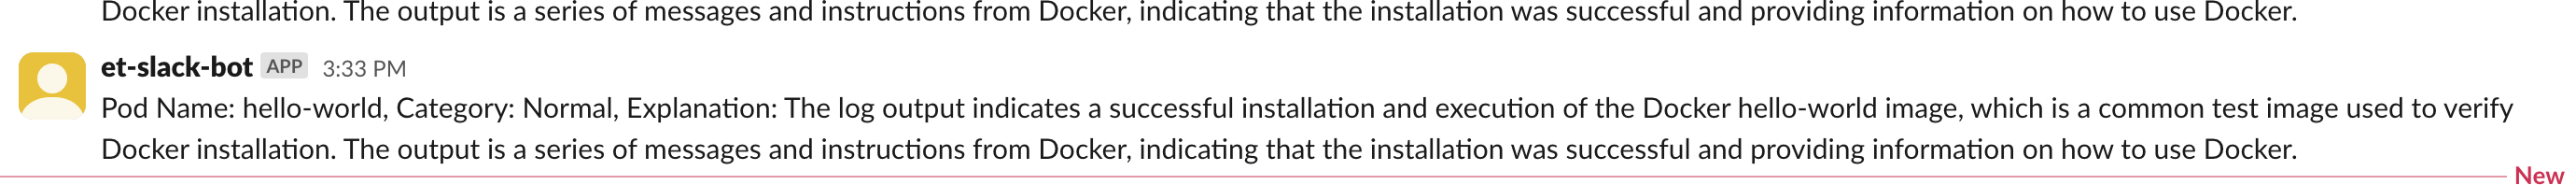

In [24]:
from IPython.display import Image, display

display(Image(filename='../../../images/slack-message.png'))

In the screenshot above, you can see that our `et-slack-bot` which is configured to both our public Slack workspace and the Slack MCP server, successfully posted a pod status summary message in the #demos channel.

### Output Analysis

Lets step through the output to further understands whats happening in this Agentic demo.

1. First the LLM sends off a tool call to the pods_log tool configured with the OpenShift MCP server, to fetch the logs for the pod specified from the OpenShift cluster.
2. The tool successfully retrieves the logs for the pod.
3. The LLM recieves the response from the tool call, which are the pod logs, along with the original query.
4. Finally, this context gets passed back to the LLM for the final inference. The inference result provides the final answer in a structured table format as requested in the user prompt and provides the pod name, its category of 'Normal' or 'Error' along with a brief explanantion.

## Key Takeaways

This tutorial demonstrates how to build agentic MCP applications with Llama Stack. We do so by initializing an agent while giving it access to the MCP tools configured with Llama Stack, then invoking the agent on each of the specified queries. Please check out our other notebooks for more examples using Llama Stack.